In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD 
from torch import nn

In [2]:
import utils_generic as generic
import rrnn_st as rrnn
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskSimple(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskSimple(md_tokenized,task,eval=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# ABOUT

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [14]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about'

In [15]:
for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.48341836734693877 

Using scikit learn accuracy por género en el conjunto about
MALE 0.7760416666666666
FEMALE 0.2025 

GLOBAL: 0.5075757575757576 

Using scikit learn accuracy por género en el conjunto to
MALE 0.7639902676399026
FEMALE 0.23097112860892388 

GLOBAL: 0.5371577574967406 

Using scikit learn accuracy por género en el conjunto as
MALE 0.8131313131313131
FEMALE 0.24258760107816713 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6917230897041148 	 Validation loss: 0.6899682283401489 	 
  1%|          | 574/57400 [00:02<03:36, 262.51it/s]
Epoch 2 	 Training loss: 0.6876432257039207 	 Validation loss: 0.6872827663259992 	 
  2%|▏         | 1148/57400 [00:04<03:34, 262.34it/s]
Epoch 3 	 Training loss: 0.6851720893009199 	 Validation loss: 0.6859493821354236 	 
  3%|▎         | 1722/57400 [00:07<03:34, 259.08it/s]
Epoch 4 	 Training loss: 0.6836617582766437 	 Validation loss: 0.6851413805606001 	 
  4%|▍         | 2296/57400 [00:09<03:27, 265.73it/s]
Epoch 5 	 Training loss: 0.6827451711332341 	 Validation loss: 0.684552340184228 	 
  5%|▌         | 2870/57400 [00:11<03:27, 262.96it/s]
Epoch 6 	 Training loss: 0.6821908003777162 	 Validation loss: 0.6843029119200625 	 
  6%|▌         | 3444/57400 [00:14<03:32, 254.34it/s]
Epoch 7 	 Training loss: 0.681853939431885 	 Validation loss: 0.6841521626811916 	 
  7%|▋         | 4018/57400 [00:16<03:19, 267.58it/s]
Epoch 8 	 Training loss: 0.681

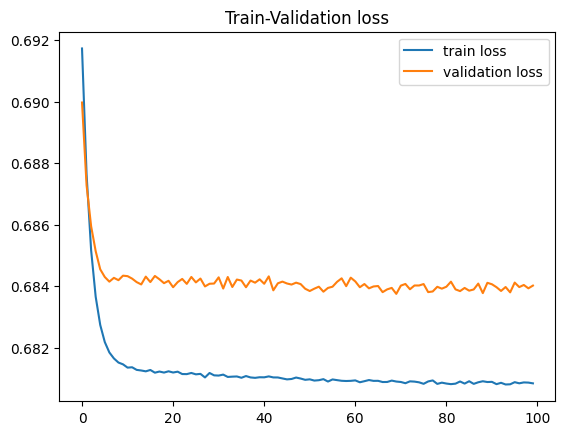

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.4897959183673469 

Using scikit learn accuracy por género en el conjunto about
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.5189393939393939 

Using scikit learn accuracy por género en el conjunto to
MALE 1.0
FEMALE 0.0 

GLOBAL: 0.516297262059974 

Using scikit learn accuracy por género en el conjunto as
MALE 1.0
FEMALE 0.0 



# TO

In [18]:
emb_dim = 20
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

In [19]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936125063730034 	 Validation loss: 0.6917314802185964 	 
  1%|          | 574/57400 [00:02<04:26, 213.02it/s]
Epoch 2 	 Training loss: 0.6935591770381462 	 Validation loss: 0.6921617449340174 	 
  2%|▏         | 1148/57400 [00:05<04:26, 211.00it/s]
Epoch 3 	 Training loss: 0.6932359082358224 	 Validation loss: 0.6920930470450449 	 
  3%|▎         | 1722/57400 [00:08<04:21, 212.90it/s]
Epoch 4 	 Training loss: 0.6933349631596941 	 Validation loss: 0.6922560687792503 	 
  4%|▍         | 2296/57400 [00:11<04:16, 215.15it/s]
Epoch 5 	 Training loss: 0.6931657075674277 	 Validation loss: 0.6921851695594141 	 
  5%|▌         | 2870/57400 [00:14<04:13, 214.92it/s]
Epoch 6 	 Training loss: 0.6931016336127025 	 Validation loss: 0.6924865367048878 	 
  6%|▌         | 3444/57400 [00:17<04:11, 214.27it/s]
Epoch 7 	 Training loss: 0.6932201325270357 	 Validation loss: 0.6923307422864236 	 
  7%|▋         | 4018/57400 [00:20<04:11, 212.37it/s]
Epoch 8 	 Training loss: 0.6

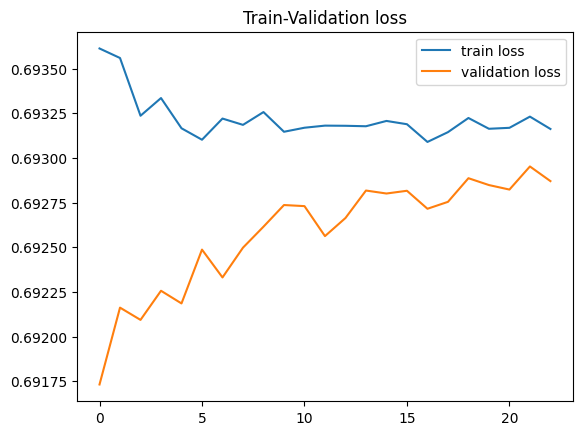

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5102040816326531 

Using scikit learn accuracy por género en el conjunto about
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810606060606061 

Using scikit learn accuracy por género en el conjunto to
MALE 0.0
FEMALE 1.0 

GLOBAL: 0.4810951760104302 

Using scikit learn accuracy por género en el conjunto as
MALE 0.0
FEMALE 0.9946091644204852 



# AS

In [22]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932403684077778 	 Validation loss: 0.693159492339118 	 
  1%|          | 574/57400 [00:02<04:25, 214.21it/s]
Epoch 2 	 Training loss: 0.6932213478802803 	 Validation loss: 0.6930772116628744 	 
  2%|▏         | 1148/57400 [00:05<04:24, 212.61it/s]
Epoch 3 	 Training loss: 0.693243788613675 	 Validation loss: 0.6929594530897626 	 
  3%|▎         | 1722/57400 [00:08<04:20, 213.80it/s]
Epoch 4 	 Training loss: 0.6932802986392577 	 Validation loss: 0.6928514939243511 	 
  4%|▍         | 2296/57400 [00:11<04:14, 216.51it/s]
Epoch 5 	 Training loss: 0.6932831893606883 	 Validation loss: 0.6927678534540079 	 
  5%|▌         | 2870/57400 [00:14<04:15, 213.30it/s]
Epoch 6 	 Training loss: 0.6932101400264049 	 Validation loss: 0.6928452869593087 	 
  6%|▌         | 3444/57400 [00:17<04:13, 212.86it/s]
Epoch 7 	 Training loss: 0.6931990833647991 	 Validation loss: 0.6927365206055722 	 
  7%|▋         | 4018/57400 [00:20<04:06, 216.64it/s]
Epoch 8 	 Training loss: 0.693

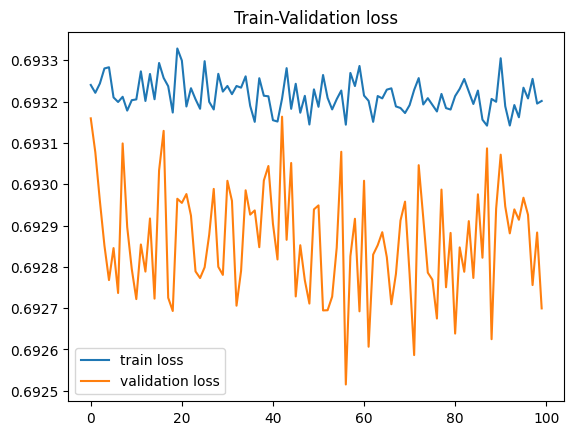

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:
model = rrnn.SingleTaskRRNN(emb_dim,vocab_size,lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))

for task in ['about','to','as']:
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}",'\n')
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

GLOBAL: 0.5267857142857143 

Using scikit learn accuracy por género en el conjunto about
MALE 0.14583333333333334
FEMALE 0.8925 

GLOBAL: 0.4861111111111111 

Using scikit learn accuracy por género en el conjunto to
MALE 0.1386861313868613
FEMALE 0.8608923884514436 

GLOBAL: 0.4758800521512386 

Using scikit learn accuracy por género en el conjunto as
MALE 0.11363636363636363
FEMALE 0.862533692722372 

